In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("./multiscale-ssh")))  # replace with real path

from DL_models import UNet  
from DL_models import CNN
from loss_function import CombinedLoss
from train_test import train_model, train_model_r2
from train_test import evaluate_model_sr
from visualization import plot_predictions_vs_targets
from visualization import plot_mean_power_spectrum
from visualization import plot_train_val_losses
from visualization import plot_mean_esr
from dataloading import prepare_dataloaders
from qualitative_eval import mse, r2_score, pearson_corr

In [2]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
import os
import xrft
import gcm_filters
import random
import scipy
from scipy.ndimage import convolve

warnings.filterwarnings("ignore")

# importlib.reload(preprocessing)
# from preprocessing import preprocess_data

# from model_eval_plotting import evaluate_model
# from model_eval_plotting import plot_predictions_vs_targets

# from CNN_setup import SimpleCNN
# from CNN_setup import TensorDataset

# from gcm_filtering import filter_inputs_dataset
# from gcm_filtering import filter_inputs

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

/srv/conda/envs/notebook/lib/python3.12/site-packages/pop_tools/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [3]:
def r2_per_sample(y_true, y_pred):
    n_samples = y_true.shape[0]
    r2_scores = np.empty(n_samples)
    
    for i in range(n_samples):
        yt = y_true[i].reshape(-1)
        yp = y_pred[i].reshape(-1)
        ss_res = np.sum((yt - yp) ** 2)
        ss_tot = np.sum((yt - np.mean(yt)) ** 2)
        r2_scores[i] = 1 - ss_res / ss_tot
    
    return r2_scores

# Data Preprocessing

In [4]:
ds_HR_reg = xr.open_dataset("gs://leap-persistent/panalluri/ds_HR_globalRegions.zarr", engine="zarr", chunks={}) 
ds_LR_reg = xr.open_dataset("gs://leap-persistent/panalluri/ds_LR_globalRegions.zarr", engine="zarr", chunks={}) 
ds_HF_reg = xr.open_dataset("gs://leap-persistent/panalluri/ds_HF_globalRegions.zarr", engine="zarr", chunks={}) 

# u_rel Testing

In [5]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='u_relative', batch_size=32, normalization_type='normalization', normalization_stats = True)

Training set size: 6132
Validation set size: 1314
Testing set size: 1314


In [6]:
# Set the values you want
in_channels = 1  # num of input channels
image_height = LR_test.shape[1]
image_width = LR_test.shape[2]
output_channels = 1 

# Instantiate the model with the parameters
model = CNN(in_channels, image_height, image_width, output_channels)
model

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=20736, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=22500, bias=True)
)

In [9]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_losses, val_losses, r2_vals = train_model_r2(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_CNN_urel_norm_global.pth', 
            n_epochs=2000, r2_stop_threshold=0.9999, delta=1e-3) # n_epochs=2000) # model_CNN_norm

Trainable Parameters: 5580132
Resuming from epoch 203 with best r2 values [0.9959716796875, 0.9959555268287659, 0.9959856867790222, 0.9960389733314514, 0.996055006980896]
Epoch 204, Train Loss: 8.363e-05, Val Loss: 8.874e-05, Val R²: 0.9960, Epoch Time: 66.99s
Patience counter: 1/10
Epoch 205, Train Loss: 8.421e-05, Val Loss: 8.669e-05, Val R²: 0.9960, Epoch Time: 58.84s
Patience counter: 2/10
Epoch 206, Train Loss: 8.988e-05, Val Loss: 1.070e-04, Val R²: 0.9951, Epoch Time: 53.24s
Patience counter: 3/10
Epoch 207, Train Loss: 8.372e-05, Val Loss: 8.619e-05, Val R²: 0.9961, Epoch Time: 49.64s
Patience counter: 4/10
Epoch 208, Train Loss: 8.226e-05, Val Loss: 8.780e-05, Val R²: 0.9960, Epoch Time: 50.17s
Patience counter: 5/10
Epoch 209, Train Loss: 8.275e-05, Val Loss: 8.662e-05, Val R²: 0.9960, Epoch Time: 50.41s
Patience counter: 6/10
Epoch 210, Train Loss: 8.474e-05, Val Loss: 8.585e-05, Val R²: 0.9961, Epoch Time: 49.59s
Patience counter: 7/10
Epoch 211, Train Loss: 8.302e-05, Val 

In [7]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_CNN_urel_norm_global.pth') # model_CNN_norm
sr_pred

Loaded model parameters from ./model_CNN_urel_norm_global.pth


<xarray.DataArray (time: 1314, yt_ocean: 150, xt_ocean: 150)> Size: 118MB
array([[[0.32301915, 0.32337144, 0.3236676 , ..., 0.3082841 ,
         0.30863982, 0.30825135],
        [0.3218022 , 0.32168537, 0.3235937 , ..., 0.3083649 ,
         0.30805176, 0.30652848],
        [0.3221103 , 0.32240155, 0.32094222, ..., 0.30652025,
         0.30630776, 0.30521625],
        ...,
        [0.34758455, 0.34772018, 0.3488096 , ..., 0.3614174 ,
         0.36211115, 0.36312795],
        [0.34917766, 0.34971035, 0.35004944, ..., 0.3619061 ,
         0.3612361 , 0.36158112],
        [0.34991068, 0.35084695, 0.350591  , ..., 0.3617073 ,
         0.36271065, 0.36149973]],

       [[0.6294881 , 0.63078094, 0.62812644, ..., 0.66387206,
         0.66891277, 0.6647968 ],
        [0.631876  , 0.6313939 , 0.63230705, ..., 0.66144806,
         0.66459703, 0.6675513 ],
        [0.6353141 , 0.63411397, 0.6335903 , ..., 0.6620367 ,
         0.66535735, 0.6640349 ],
...
        [0.40641057, 0.40500292, 0.4061033 , ..., 0.40541893,
         0.40665692, 0.4029315 ],
        [0.4102986 , 0.4093063 , 0.40988538, ..., 0.40219754,
         0.40152055, 0.401395  ],
        [0.40956783, 0.4101072 , 0.40930483, ..., 0.4010191 ,
         0.4033152 , 0.39852446]],

       [[0.36197954, 0.36156726, 0.3615727 , ..., 0.38976526,
         0.3897966 , 0.39271706],
        [0.36404532, 0.36299732, 0.36214378, ..., 0.39325923,
         0.3938074 , 0.39466006],
        [0.363863  , 0.36555588, 0.3650455 , ..., 0.39561468,
         0.3966701 , 0.39752337],
        ...,
        [0.33919352, 0.34087312, 0.34029108, ..., 0.54040015,
         0.5436264 , 0.5432024 ],
        [0.34118706, 0.33994272, 0.341093  , ..., 0.5426186 ,
         0.5418232 , 0.5432263 ],
        [0.33896413, 0.33888412, 0.33998358, ..., 0.5439786 ,
         0.5454453 , 0.5452776 ]]], shape=(1314, 150, 150), dtype=float32)
Coordinates:
  * time      (time) int64 11kB 5608 2559 2052 5144 7318 ... 7185 4647 7653 1905
  * yt_ocean  (yt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
  * xt_ocean  (xt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150

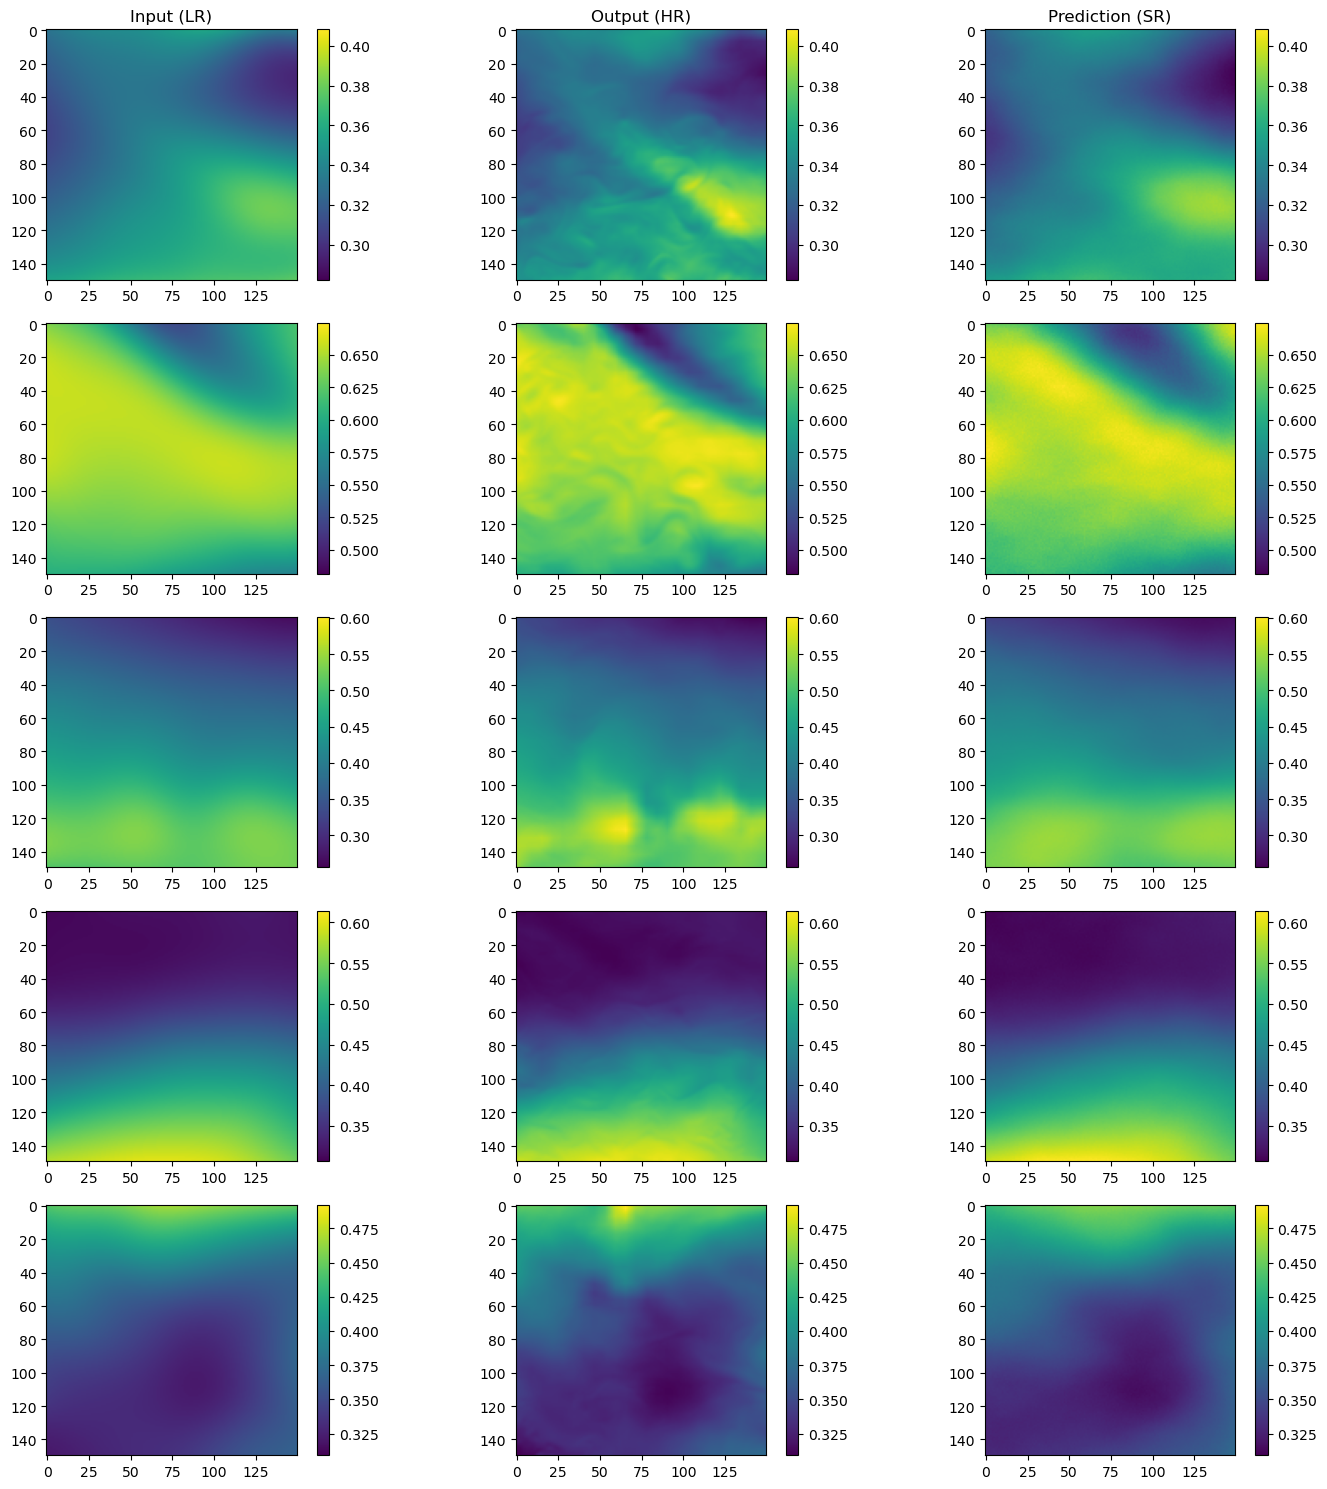

In [8]:
plot_predictions_vs_targets(LR_test, HR_test, sr_pred, num_samples=5, cmap='viridis')

In [9]:
r2_scores_urel = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_urel)
best_r2 = r2_scores_urel[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9990 at index 878


In [10]:
r2_scores_urel = r2_per_sample(HR_test.values, sr_pred.values)

worst_index = np.argmin(r2_scores_urel)
worst_r2 = r2_scores_urel[worst_index]

print(f"Worst R² = {worst_r2:.4f} at index {worst_index}")

Worst R² = 0.6951 at index 126


In [11]:
min_val, max_val = norm_stats
urel_HR_test = HR_test * (max_val - min_val) + min_val
urel_LR_test = LR_test * (max_val - min_val) + min_val
urel_sr_pred = sr_pred * (max_val - min_val) + min_val

# v_rel Testing

In [12]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='v_relative', batch_size=32, normalization_type='normalization')

Training set size: 6132
Validation set size: 1314
Testing set size: 1314


In [16]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_losses, val_losses, r2_vals = train_model_r2(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_CNN_vrel_norm_global.pth', 
            n_epochs=2000, r2_stop_threshold=0.9999, delta=1e-3) # n_epochs=2000) 

Trainable Parameters: 5580132
Epoch 1, Train Loss: 2.036e-04, Val Loss: 1.016e-04, Val R²: 0.9912, Epoch Time: 48.49s
Model saved at epoch 1
Epoch 2, Train Loss: 1.092e-04, Val Loss: 9.756e-05, Val R²: 0.9915, Epoch Time: 48.14s
Model saved at epoch 2
Epoch 3, Train Loss: 1.075e-04, Val Loss: 9.858e-05, Val R²: 0.9914, Epoch Time: 48.27s
Model saved at epoch 3
Epoch 4, Train Loss: 1.087e-04, Val Loss: 1.345e-04, Val R²: 0.9883, Epoch Time: 51.57s
Model saved at epoch 4
Epoch 5, Train Loss: 1.107e-04, Val Loss: 1.031e-04, Val R²: 0.9910, Epoch Time: 58.05s
Model saved at epoch 5
Epoch 6, Train Loss: 1.150e-04, Val Loss: 9.911e-05, Val R²: 0.9914, Epoch Time: 49.45s
Model saved at epoch 6
Epoch 7, Train Loss: 1.058e-04, Val Loss: 9.533e-05, Val R²: 0.9917, Epoch Time: 49.03s
Model saved at epoch 7
Epoch 8, Train Loss: 1.059e-04, Val Loss: 9.299e-05, Val R²: 0.9919, Epoch Time: 48.39s
Model saved at epoch 8
Epoch 9, Train Loss: 1.055e-04, Val Loss: 9.544e-05, Val R²: 0.9917, Epoch Time: 6

In [13]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_CNN_vrel_norm_global.pth')
sr_pred

Loaded model parameters from ./model_CNN_vrel_norm_global.pth


<xarray.DataArray (time: 1314, yt_ocean: 150, xt_ocean: 150)> Size: 118MB
array([[[0.35849476, 0.35891587, 0.3588939 , ..., 0.4590348 ,
         0.46046004, 0.46087354],
        [0.3582497 , 0.35884297, 0.359177  , ..., 0.4594127 ,
         0.46141273, 0.4619465 ],
        [0.35986614, 0.36039048, 0.35977536, ..., 0.46119744,
         0.4617691 , 0.46260107],
        ...,
        [0.5045878 , 0.50430894, 0.5053204 , ..., 0.5612922 ,
         0.56024235, 0.55976856],
        [0.50414693, 0.5051265 , 0.50495684, ..., 0.55940324,
         0.5597684 , 0.55888265],
        [0.5034783 , 0.50505626, 0.5048953 , ..., 0.55935156,
         0.5580842 , 0.55806625]],

       [[0.47814143, 0.4781357 , 0.47921467, ..., 0.54095554,
         0.5396221 , 0.5403657 ],
        [0.47718662, 0.47794217, 0.47791225, ..., 0.538763  ,
         0.54048836, 0.54025924],
        [0.47748858, 0.47847   , 0.47959882, ..., 0.540399  ,
         0.5388815 , 0.5402566 ],
...
        [0.3436467 , 0.34296125, 0.34324878, ..., 0.45400473,
         0.45221323, 0.45246983],
        [0.34108502, 0.34011883, 0.3398286 , ..., 0.45185292,
         0.45295072, 0.45007378],
        [0.3370555 , 0.3386424 , 0.33676827, ..., 0.45108846,
         0.44942242, 0.451245  ]],

       [[0.38574582, 0.38472688, 0.3828885 , ..., 0.27769893,
         0.2796393 , 0.2802796 ],
        [0.3849123 , 0.38347566, 0.38282675, ..., 0.2779947 ,
         0.2800559 , 0.2808863 ],
        [0.38473895, 0.38309604, 0.3813501 , ..., 0.27914205,
         0.2803171 , 0.28145587],
        ...,
        [0.42885667, 0.42779145, 0.427345  , ..., 0.40661   ,
         0.4070602 , 0.40772873],
        [0.42916894, 0.42860758, 0.42744422, ..., 0.4068042 ,
         0.40751323, 0.40902054],
        [0.42913896, 0.42837343, 0.4272964 , ..., 0.40831825,
         0.40850303, 0.40924555]]], shape=(1314, 150, 150), dtype=float32)
Coordinates:
  * time      (time) int64 11kB 1093 8705 7364 3391 4143 ... 8327 6915 1582 6657
  * yt_ocean  (yt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
  * xt_ocean  (xt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150

In [14]:
r2_scores_vrel = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_vrel)
best_r2 = r2_scores_vrel[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9986 at index 593


In [15]:
min_val, max_val = norm_stats
vrel_HR_test = HR_test * (max_val - min_val) + min_val
vrel_LR_test = LR_test * (max_val - min_val) + min_val
vrel_sr_pred = sr_pred * (max_val - min_val) + min_val

# t_ref Testing

In [16]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='t_ref', batch_size=32, normalization_type='normalization')

Training set size: 6132
Validation set size: 1314
Testing set size: 1314


In [21]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_losses, val_losses, r2_vals = train_model_r2(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_CNN_tref_norm_global.pth', 
            n_epochs=2000, r2_stop_threshold=0.9999, delta=1e-4) # n_epochs=2000) 

Trainable Parameters: 5580132
Epoch 1, Train Loss: 3.242e-04, Val Loss: 2.861e-05, Val R²: 0.9991, Epoch Time: 47.94s
Model saved at epoch 1
Epoch 2, Train Loss: 2.375e-05, Val Loss: 2.265e-05, Val R²: 0.9993, Epoch Time: 48.26s
Model saved at epoch 2
Epoch 3, Train Loss: 2.192e-05, Val Loss: 2.163e-05, Val R²: 0.9993, Epoch Time: 48.79s
Model saved at epoch 3
Epoch 4, Train Loss: 2.375e-05, Val Loss: 2.522e-05, Val R²: 0.9992, Epoch Time: 48.50s
Model saved at epoch 4
Epoch 5, Train Loss: 2.862e-05, Val Loss: 2.401e-05, Val R²: 0.9993, Epoch Time: 48.46s
Model saved at epoch 5
Epoch 6, Train Loss: 3.051e-05, Val Loss: 3.190e-05, Val R²: 0.9990, Epoch Time: 48.72s
Model saved at epoch 6
Epoch 7, Train Loss: 3.467e-05, Val Loss: 2.060e-05, Val R²: 0.9994, Epoch Time: 49.45s
Model saved at epoch 7
Epoch 8, Train Loss: 2.845e-05, Val Loss: 1.771e-05, Val R²: 0.9995, Epoch Time: 48.58s
Model saved at epoch 8
Epoch 9, Train Loss: 2.928e-05, Val Loss: 3.234e-05, Val R²: 0.9990, Epoch Time: 4

In [17]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_CNN_tref_norm_global.pth')
sr_pred

Loaded model parameters from ./model_CNN_tref_norm_global.pth


<xarray.DataArray (time: 1314, yt_ocean: 150, xt_ocean: 150)> Size: 118MB
array([[[0.81214   , 0.8116421 , 0.81120455, ..., 0.83059335,
         0.83089745, 0.8311341 ],
        [0.8133118 , 0.81354123, 0.81276435, ..., 0.8307384 ,
         0.83130634, 0.83104205],
        [0.81507415, 0.81425744, 0.81415594, ..., 0.8311223 ,
         0.8320338 , 0.83237445],
        ...,
        [0.8845329 , 0.8844011 , 0.88397634, ..., 0.8590307 ,
         0.858628  , 0.85770154],
        [0.88482916, 0.88422596, 0.8837333 , ..., 0.8601109 ,
         0.8592534 , 0.8582307 ],
        [0.8847234 , 0.88445115, 0.88333166, ..., 0.86064243,
         0.8596491 , 0.8592275 ]],

       [[0.37961   , 0.3790676 , 0.37876588, ..., 0.3184697 ,
         0.31807935, 0.31835997],
        [0.37989676, 0.37955213, 0.37883964, ..., 0.31892908,
         0.31919262, 0.31888074],
        [0.38029712, 0.38007343, 0.37961507, ..., 0.31972402,
         0.31920955, 0.3197739 ],
...
        [0.82560635, 0.8256329 , 0.825664  , ..., 0.83480626,
         0.8346169 , 0.8341347 ],
        [0.82444406, 0.824044  , 0.82435113, ..., 0.83426094,
         0.8339485 , 0.8331197 ],
        [0.8232207 , 0.82287   , 0.82278734, ..., 0.83320063,
         0.83325654, 0.8325099 ]],

       [[0.84135187, 0.84085625, 0.8403541 , ..., 0.7958773 ,
         0.7960235 , 0.7962041 ],
        [0.84062207, 0.8406587 , 0.83978677, ..., 0.7949013 ,
         0.79541934, 0.79479396],
        [0.84036666, 0.83937734, 0.83896756, ..., 0.7940991 ,
         0.79484284, 0.795418  ],
        ...,
        [0.6551113 , 0.6551402 , 0.655563  , ..., 0.6657934 ,
         0.665612  , 0.6652096 ],
        [0.65248084, 0.65217197, 0.6522327 , ..., 0.66479933,
         0.6645864 , 0.6634417 ],
        [0.6494899 , 0.6493888 , 0.64896536, ..., 0.662882  ,
         0.6629561 , 0.6627085 ]]], shape=(1314, 150, 150), dtype=float32)
Coordinates:
  * time      (time) int64 11kB 777 5948 3410 4971 3372 ... 7917 5467 5499 536
  * yt_ocean  (yt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
  * xt_ocean  (xt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150

In [18]:
r2_scores_tref = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_tref)
best_r2 = r2_scores_tref[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9990 at index 1231


In [19]:
min_val, max_val = norm_stats
tref_HR_test = HR_test * (max_val - min_val) + min_val
tref_LR_test = LR_test * (max_val - min_val) + min_val
tref_sr_pred = sr_pred * (max_val - min_val) + min_val

# q_ref Testing

In [20]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='q_ref', batch_size=32, normalization_type='normalization')

Training set size: 6132
Validation set size: 1314
Testing set size: 1314


In [21]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_losses, val_losses, r2_vals = train_model_r2(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_CNN_qref_norm_global.pth', 
            n_epochs=2000, r2_stop_threshold=0.9999, delta=1e-3) # n_epochs=2000) 

Trainable Parameters: 5580132
Resuming from epoch 23 with best r2 values []
Epoch 24, Train Loss: 1.025e-04, Val Loss: 9.865e-05, Val R²: 0.9981, Epoch Time: 50.45s
Model saved at epoch 24
Epoch 25, Train Loss: 1.007e-04, Val Loss: 9.943e-05, Val R²: 0.9981, Epoch Time: 47.17s
Model saved at epoch 25
Epoch 26, Train Loss: 1.014e-04, Val Loss: 9.845e-05, Val R²: 0.9981, Epoch Time: 47.18s
Model saved at epoch 26
Epoch 27, Train Loss: 1.040e-04, Val Loss: 9.729e-05, Val R²: 0.9981, Epoch Time: 47.11s
Model saved at epoch 27
Epoch 28, Train Loss: 1.002e-04, Val Loss: 9.851e-05, Val R²: 0.9981, Epoch Time: 47.98s
Model saved at epoch 28
Epoch 29, Train Loss: 1.007e-04, Val Loss: 1.129e-04, Val R²: 0.9978, Epoch Time: 46.69s
Model saved at epoch 29
Epoch 30, Train Loss: 1.064e-04, Val Loss: 9.650e-05, Val R²: 0.9982, Epoch Time: 47.79s
Model saved at epoch 30
Epoch 31, Train Loss: 1.017e-04, Val Loss: 9.772e-05, Val R²: 0.9981, Epoch Time: 46.77s
Best model so far saved to ./model_CNN_qref_

In [22]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_CNN_qref_norm_global.pth')
sr_pred

Loaded model parameters from ./model_CNN_qref_norm_global.pth


<xarray.DataArray (time: 1314, yt_ocean: 150, xt_ocean: 150)> Size: 118MB
array([[[0.76682585, 0.7667816 , 0.7658306 , ..., 0.7130884 ,
         0.7137529 , 0.71206856],
        [0.7682173 , 0.77010465, 0.7690737 , ..., 0.7123291 ,
         0.71146023, 0.70841616],
        [0.7724526 , 0.77104485, 0.77063113, ..., 0.7106642 ,
         0.7126217 , 0.71099854],
        ...,
        [0.7273658 , 0.72752535, 0.7283081 , ..., 0.77347463,
         0.7746835 , 0.7743617 ],
        [0.7248244 , 0.72441024, 0.72349274, ..., 0.7741739 ,
         0.77326417, 0.772823  ],
        [0.72163606, 0.72088337, 0.7181473 , ..., 0.7713671 ,
         0.7720981 , 0.77211666]],

       [[0.6920823 , 0.6923536 , 0.69362974, ..., 0.6052946 ,
         0.6042669 , 0.603456  ],
        [0.6933346 , 0.6934865 , 0.6945724 , ..., 0.60627556,
         0.6049602 , 0.6048762 ],
        [0.6939564 , 0.693673  , 0.69529533, ..., 0.6084709 ,
         0.6078193 , 0.6065692 ],
...
        [0.6299333 , 0.631005  , 0.6309734 , ..., 0.68216246,
         0.6842234 , 0.68442476],
        [0.6281837 , 0.6276778 , 0.6287095 , ..., 0.6811511 ,
         0.68099654, 0.6818911 ],
        [0.6276794 , 0.6259997 , 0.62540257, ..., 0.67699957,
         0.6794021 , 0.67862046]],

       [[0.39943403, 0.40046674, 0.40209186, ..., 0.60581505,
         0.6042952 , 0.60438275],
        [0.39605555, 0.3972884 , 0.39915028, ..., 0.6052704 ,
         0.6045775 , 0.6042303 ],
        [0.39110634, 0.39266244, 0.39589706, ..., 0.60263646,
         0.60259616, 0.6030159 ],
        ...,
        [0.09566113, 0.09764408, 0.09765873, ..., 0.17898637,
         0.1806485 , 0.18002562],
        [0.09326032, 0.09332668, 0.09545657, ..., 0.178523  ,
         0.17855708, 0.17841557],
        [0.09237091, 0.09184554, 0.09355982, ..., 0.17571908,
         0.17773187, 0.17661093]]], shape=(1314, 150, 150), dtype=float32)
Coordinates:
  * time      (time) int64 11kB 1602 8081 3766 693 4955 ... 4916 8564 7759 4759
  * yt_ocean  (yt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
  * xt_ocean  (xt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150

In [23]:
r2_scores_qref = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_qref)
best_r2 = r2_scores_qref[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9976 at index 62


In [24]:
min_val, max_val = norm_stats
qref_HR_test = HR_test * (max_val - min_val) + min_val
qref_LR_test = LR_test * (max_val - min_val) + min_val
qref_sr_pred = sr_pred * (max_val - min_val) + min_val

# SLP Testing

In [25]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='slp', batch_size=32, normalization_type='normalization')

Training set size: 6132
Validation set size: 1314
Testing set size: 1314


In [26]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_losses, val_losses, r2_vals = train_model_r2(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_CNN_slp_norm_global.pth', 
            n_epochs=2000, r2_stop_threshold=0.9999, delta=1e-3) # n_epochs=2000) 

Trainable Parameters: 5580132
Epoch 1, Train Loss: 1.667e-04, Val Loss: 1.365e-05, Val R²: 0.9988, Epoch Time: 46.55s
Model saved at epoch 1
Epoch 2, Train Loss: 9.418e-06, Val Loss: 1.098e-05, Val R²: 0.9990, Epoch Time: 46.32s
Model saved at epoch 2
Epoch 3, Train Loss: 8.803e-06, Val Loss: 9.644e-06, Val R²: 0.9992, Epoch Time: 47.12s
Model saved at epoch 3
Epoch 4, Train Loss: 1.119e-05, Val Loss: 6.594e-06, Val R²: 0.9994, Epoch Time: 46.79s
Model saved at epoch 4
Epoch 5, Train Loss: 1.005e-05, Val Loss: 2.755e-05, Val R²: 0.9977, Epoch Time: 46.85s
Model saved at epoch 5
Epoch 6, Train Loss: 1.104e-05, Val Loss: 1.253e-05, Val R²: 0.9990, Epoch Time: 46.65s
Model saved at epoch 6
Epoch 7, Train Loss: 1.191e-05, Val Loss: 1.051e-05, Val R²: 0.9992, Epoch Time: 47.18s
Model saved at epoch 7
Epoch 8, Train Loss: 2.416e-05, Val Loss: 1.087e-05, Val R²: 0.9991, Epoch Time: 47.08s
Model saved at epoch 8
Epoch 9, Train Loss: 1.511e-05, Val Loss: 2.393e-05, Val R²: 0.9981, Epoch Time: 4

In [27]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_CNN_slp_norm_global.pth')
sr_pred

Loaded model parameters from ./model_CNN_slp_norm_global.pth


<xarray.DataArray (time: 1314, yt_ocean: 150, xt_ocean: 150)> Size: 118MB
array([[[0.7310748 , 0.73110473, 0.73100513, ..., 0.72784984,
         0.7279353 , 0.7278015 ],
        [0.73065853, 0.73072684, 0.7306873 , ..., 0.7275457 ,
         0.72755253, 0.7273447 ],
        [0.73049545, 0.73048604, 0.7303186 , ..., 0.7272676 ,
         0.72729194, 0.7271904 ],
        ...,
        [0.7023502 , 0.7022255 , 0.7021981 , ..., 0.69746447,
         0.69744444, 0.6973339 ],
        [0.7024578 , 0.7023216 , 0.7021603 , ..., 0.6974944 ,
         0.69744194, 0.6973713 ],
        [0.7024078 , 0.70228624, 0.702121  , ..., 0.69756866,
         0.69751143, 0.69748354]],

       [[0.70850635, 0.70954204, 0.7104222 , ..., 0.840712  ,
         0.84145945, 0.84142923],
        [0.707435  , 0.70866406, 0.70948493, ..., 0.84098387,
         0.8413001 , 0.8414709 ],
        [0.70725954, 0.7081869 , 0.7085987 , ..., 0.84153366,
         0.8419962 , 0.8418869 ],
...
        [0.7372259 , 0.73710823, 0.737007  , ..., 0.7544385 ,
         0.7553857 , 0.7562246 ],
        [0.7369396 , 0.73684376, 0.7366409 , ..., 0.7532704 ,
         0.7541897 , 0.75509965],
        [0.73662   , 0.7365433 , 0.73635054, ..., 0.752193  ,
         0.7530261 , 0.7539622 ]],

       [[0.703008  , 0.7035778 , 0.7040328 , ..., 0.7845158 ,
         0.78487176, 0.78494   ],
        [0.70342904, 0.70412076, 0.7046196 , ..., 0.7846711 ,
         0.7849123 , 0.78500503],
        [0.70426154, 0.70488966, 0.70527434, ..., 0.7847872 ,
         0.7850604 , 0.78513926],
        ...,
        [0.72561944, 0.7256971 , 0.72583264, ..., 0.7253939 ,
         0.72532785, 0.7251584 ],
        [0.72536933, 0.72552943, 0.725527  , ..., 0.725001  ,
         0.72495496, 0.72484416],
        [0.72509503, 0.7252854 , 0.72530293, ..., 0.724728  ,
         0.724554  , 0.72452754]]], shape=(1314, 150, 150), dtype=float32)
Coordinates:
  * time      (time) int64 11kB 2036 515 1946 1600 5186 ... 4018 6525 390 1122
  * yt_ocean  (yt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
  * xt_ocean  (xt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150

In [28]:
r2_scores_slp = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_slp)
best_r2 = r2_scores_slp[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9999 at index 879


In [29]:
min_val, max_val = norm_stats
slp_HR_test = HR_test * (max_val - min_val) + min_val
slp_LR_test = LR_test * (max_val - min_val) + min_val
slp_sr_pred = sr_pred * (max_val - min_val) + min_val

# SST Testing

In [30]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='surface_temp', batch_size=32, normalization_type='normalization')

Training set size: 6132
Validation set size: 1314
Testing set size: 1314


In [31]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_losses, val_losses, r2_vals = train_model_r2(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_CNN_sst_norm_global.pth', 
            n_epochs=2000, r2_stop_threshold=0.9999, delta=1e-3) # n_epochs=2000) 

Trainable Parameters: 5580132
Epoch 1, Train Loss: 4.582e-04, Val Loss: 2.839e-04, Val R²: 0.9956, Epoch Time: 47.53s
Model saved at epoch 1
Epoch 2, Train Loss: 2.834e-04, Val Loss: 2.690e-04, Val R²: 0.9958, Epoch Time: 47.60s
Model saved at epoch 2
Epoch 3, Train Loss: 2.693e-04, Val Loss: 2.590e-04, Val R²: 0.9960, Epoch Time: 47.26s
Model saved at epoch 3
Epoch 4, Train Loss: 2.637e-04, Val Loss: 2.584e-04, Val R²: 0.9960, Epoch Time: 48.56s
Model saved at epoch 4
Epoch 5, Train Loss: 2.624e-04, Val Loss: 2.543e-04, Val R²: 0.9961, Epoch Time: 49.08s
Model saved at epoch 5
Epoch 6, Train Loss: 2.632e-04, Val Loss: 2.541e-04, Val R²: 0.9961, Epoch Time: 49.38s
Model saved at epoch 6
Epoch 7, Train Loss: 2.607e-04, Val Loss: 2.500e-04, Val R²: 0.9961, Epoch Time: 49.73s
Model saved at epoch 7
Epoch 8, Train Loss: 2.547e-04, Val Loss: 2.785e-04, Val R²: 0.9957, Epoch Time: 49.51s
Model saved at epoch 8
Epoch 9, Train Loss: 3.281e-04, Val Loss: 2.567e-04, Val R²: 0.9960, Epoch Time: 4

In [32]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_CNN_sst_norm_global.pth')
sr_pred

Loaded model parameters from ./model_CNN_sst_norm_global.pth


<xarray.DataArray (time: 1314, yt_ocean: 150, xt_ocean: 150)> Size: 118MB
array([[[0.16866362, 0.16987252, 0.17060451, ..., 0.16726415,
         0.16728003, 0.16708449],
        [0.16999054, 0.17068823, 0.17123437, ..., 0.16680133,
         0.16676898, 0.16697103],
        [0.16989875, 0.17051774, 0.17161687, ..., 0.16720192,
         0.16706036, 0.16717172],
        ...,
        [0.34913874, 0.34928307, 0.349703  , ..., 0.33564872,
         0.3374256 , 0.34059948],
        [0.34985918, 0.34947026, 0.35091457, ..., 0.3374701 ,
         0.34011352, 0.34215352],
        [0.3515467 , 0.35085905, 0.3518116 , ..., 0.3388546 ,
         0.34170747, 0.3435468 ]],

       [[0.392918  , 0.39311188, 0.39208704, ..., 0.3472488 ,
         0.3476912 , 0.3468802 ],
        [0.3953625 , 0.39511645, 0.39441186, ..., 0.34805334,
         0.34697726, 0.3462463 ],
        [0.39820692, 0.39688134, 0.39526573, ..., 0.34944358,
         0.34916586, 0.34806207],
...
        [0.90888965, 0.9097871 , 0.91194844, ..., 0.884705  ,
         0.8850539 , 0.88664186],
        [0.9096898 , 0.909224  , 0.9100389 , ..., 0.88466996,
         0.8850444 , 0.8860468 ],
        [0.9110329 , 0.9084263 , 0.9089762 , ..., 0.885393  ,
         0.88515085, 0.8850901 ]],

       [[0.81752706, 0.8179417 , 0.8191237 , ..., 0.76883817,
         0.76815754, 0.76769257],
        [0.82253104, 0.8204093 , 0.82081   , ..., 0.76952606,
         0.7671801 , 0.7682061 ],
        [0.8245301 , 0.82360107, 0.8225612 , ..., 0.77255756,
         0.7703099 , 0.76924986],
        ...,
        [0.93616486, 0.9377551 , 0.938907  , ..., 0.90288603,
         0.90318763, 0.906595  ],
        [0.93643045, 0.93708473, 0.93951863, ..., 0.90372145,
         0.90599316, 0.90695035],
        [0.93983793, 0.9378571 , 0.93932295, ..., 0.904909  ,
         0.9062566 , 0.906182  ]]], shape=(1314, 150, 150), dtype=float32)
Coordinates:
  * time      (time) int64 11kB 5843 4344 1449 5159 184 ... 4419 3254 1678 8119
  * yt_ocean  (yt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
  * xt_ocean  (xt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150

In [33]:
r2_scores_sst = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_sst)
best_r2 = r2_scores_sst[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9936 at index 261


In [34]:
min_val, max_val = norm_stats
sst_HR_test = HR_test * (max_val - min_val) + min_val
sst_LR_test = LR_test * (max_val - min_val) + min_val
sst_sr_pred = sr_pred * (max_val - min_val) + min_val

# Figures

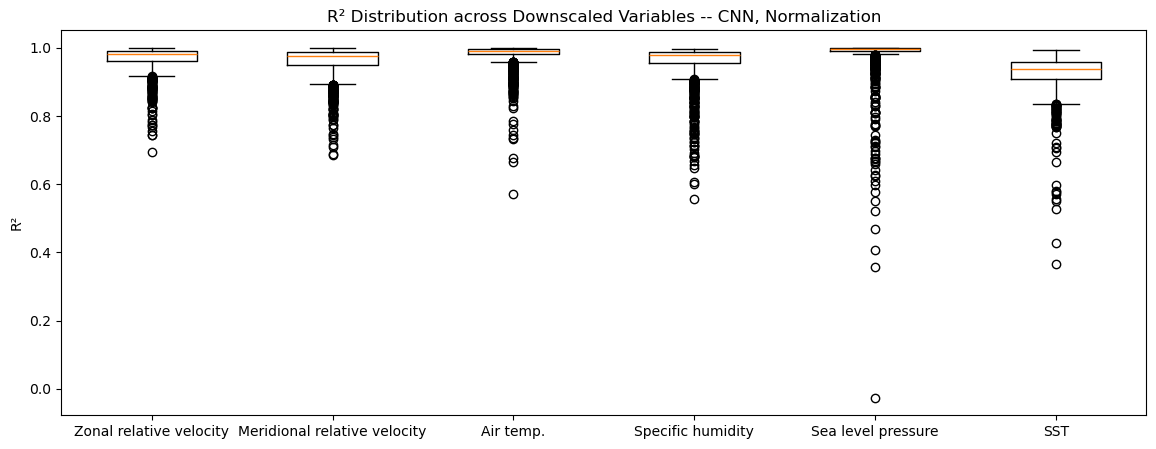

In [35]:
data = [r2_scores_urel, r2_scores_vrel, r2_scores_tref, r2_scores_qref, r2_scores_slp, r2_scores_sst]

plt.figure(figsize=(14, 5))
plt.boxplot(data, vert=True)  # each array becomes a separate boxplot
plt.xticks([1, 2, 3, 4, 5, 6], ["Zonal relative velocity", "Meridional relative velocity", 
                                        "Air temp.", "Specific humidity", "Sea level pressure", "SST"])  # label each box
plt.ylabel("R²")
plt.title("R² Distribution across Downscaled Variables -- CNN, Normalization")
plt.show()

In [36]:
# Suppose you have 6 arrays: a1, a2, ..., a6 (all same length)
arrays = [r2_scores_urel, r2_scores_vrel, r2_scores_tref, r2_scores_qref, r2_scores_slp, r2_scores_sst]

# Stack into shape (6, N) and take mean over axis=0
mean_array = np.mean(np.stack(arrays, axis=0), axis=0)

# Find the max value and its index
max_val = np.max(mean_array)
max_idx = np.argmax(mean_array)

print(f"Max value = {max_val}, at index = {max_idx}")

Max value = 0.9943402906258901, at index = 1005


In [37]:
# Find the min value and its index
min_val = np.min(mean_array)
min_idx = np.argmin(mean_array)

print(f"Min value = {min_val}, at index = {min_idx}")

Min value = 0.8009557525316874, at index = 320


In [38]:
# Make a Dataset
ds_cnn_norm = xr.Dataset()

# Manually add variables
ds_cnn_norm["u_rel_sr"] = (("time", "y", "x"), urel_sr_pred.values)
ds_cnn_norm["v_rel_sr"] = (("time", "y", "x"), vrel_sr_pred.values)
ds_cnn_norm["t_ref_sr"] = (("time", "y", "x"), tref_sr_pred.values)
ds_cnn_norm["q_ref_sr"] = (("time", "y", "x"), qref_sr_pred.values)
ds_cnn_norm["slp_sr"] = (("time", "y", "x"), slp_sr_pred.values)
ds_cnn_norm["sst_sr"] = (("time", "y", "x"), sst_sr_pred.values)

ds_cnn_norm["u_rel_hr"] = (("time", "y", "x"), urel_HR_test.values)
ds_cnn_norm["v_rel_hr"] = (("time", "y", "x"), vrel_HR_test.values)
ds_cnn_norm["t_ref_hr"] = (("time", "y", "x"), tref_HR_test.values)
ds_cnn_norm["q_ref_hr"] = (("time", "y", "x"), qref_HR_test.values)
ds_cnn_norm["slp_hr"] = (("time", "y", "x"), slp_HR_test.values)
ds_cnn_norm["sst_hr"] = (("time", "y", "x"), sst_HR_test.values)

ds_cnn_norm["u_rel_lr"] = (("time", "y", "x"), urel_LR_test)
ds_cnn_norm["v_rel_lr"] = (("time", "y", "x"), vrel_LR_test)
ds_cnn_norm["t_ref_lr"] = (("time", "y", "x"), tref_LR_test)
ds_cnn_norm["q_ref_lr"] = (("time", "y", "x"), qref_LR_test)
ds_cnn_norm["slp_lr"] = (("time", "y", "x"), slp_LR_test)
ds_cnn_norm["sst_lr"] = (("time", "y", "x"), sst_LR_test)

print(ds_cnn_norm)

<xarray.Dataset> Size: 2GB
Dimensions:   (time: 1314, y: 150, x: 150)
Dimensions without coordinates: time, y, x
Data variables: (12/18)
    u_rel_sr  (time, y, x) float32 118MB -6.811 -6.795 -6.782 ... 2.934 2.927
    v_rel_sr  (time, y, x) float32 118MB -5.026 -5.007 -5.008 ... -2.784 -2.75
    t_ref_sr  (time, y, x) float32 118MB 293.1 293.1 293.0 ... 286.2 286.2 286.2
    q_ref_sr  (time, y, x) float32 118MB 0.0168 0.0168 ... 0.004518 0.004494
    slp_sr    (time, y, x) float32 118MB 1.015e+05 1.015e+05 ... 1.015e+05
    sst_sr    (time, y, x) float32 118MB 276.8 276.8 276.8 ... 300.7 300.7 300.7
    ...        ...
    u_rel_lr  (time, y, x) float32 118MB -6.503 -6.481 -6.459 ... 2.388 2.404
    v_rel_lr  (time, y, x) float32 118MB -4.827 -4.822 -4.817 ... -3.999 -4.041
    t_ref_lr  (time, y, x) float32 118MB 292.9 292.9 292.9 ... 285.8 285.8 285.7
    q_ref_lr  (time, y, x) float32 118MB 0.01671 0.0167 ... 0.004373 0.004383
    slp_lr    (time, y, x) float32 118MB 1.015e+05 1.015

In [40]:
ds_cnn_norm.to_zarr("gs://leap-persistent/panalluri/cnn_norm_fluxInputs_global.zarr", zarr_version=2)

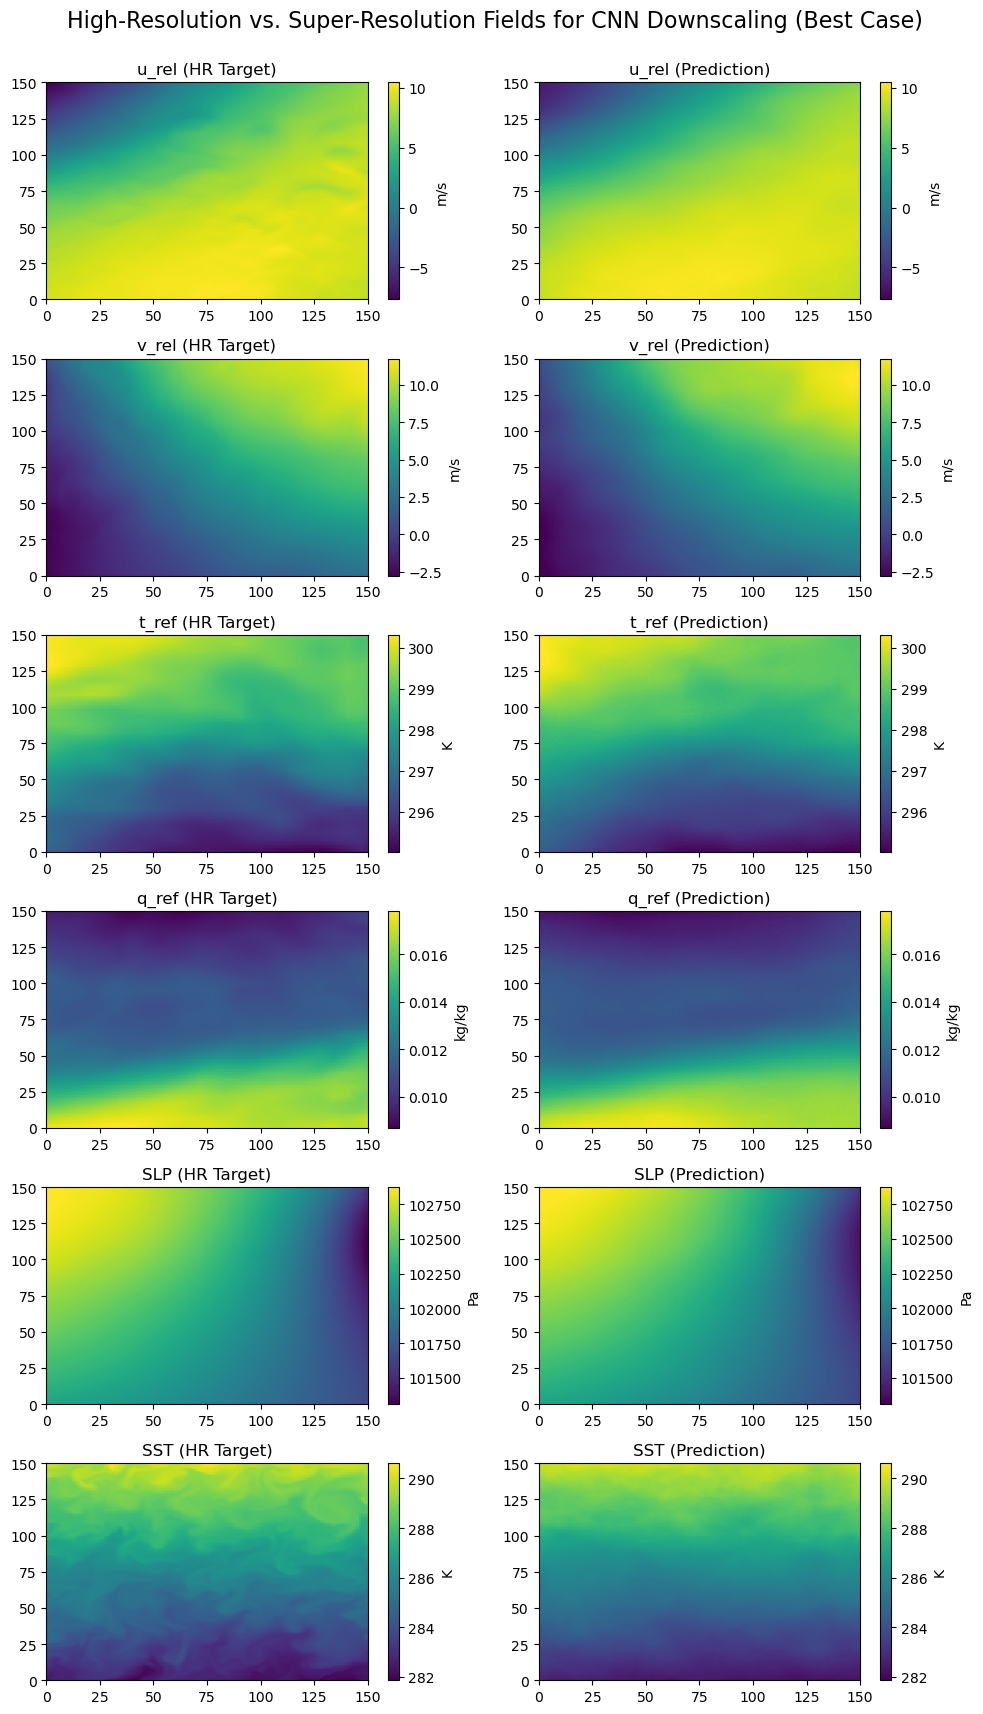

In [41]:
fig, axes = plt.subplots(6, 2, figsize=(10, 18))

vmins = [urel_HR_test[max_idx].min().values, vrel_HR_test[max_idx].min().values, tref_HR_test[max_idx].min().values,
         qref_HR_test[max_idx].min().values, slp_HR_test[max_idx].min().values, sst_HR_test[max_idx].min().values]
vmaxs = [urel_HR_test[max_idx].max().values, vrel_HR_test[max_idx].max().values, tref_HR_test[max_idx].max().values,
         qref_HR_test[max_idx].max().values, slp_HR_test[max_idx].max().values, sst_HR_test[max_idx].max().values]

# Add figure-level title
fig.suptitle("High-Resolution vs. Super-Resolution Fields for CNN Downscaling (Best Case)", fontsize=16, y=0.95)

# Top-left
im = axes[0, 0].pcolor(urel_HR_test[max_idx], vmin=vmins[0], vmax=vmaxs[0], shading='auto')
axes[0, 0].set_title("u_rel (HR Target)")
fig.colorbar(im, ax=axes[0, 0], label="m/s")

# Top-right
im = axes[0, 1].pcolor(urel_sr_pred[max_idx], vmin=vmins[0], vmax=vmaxs[0], shading='auto')
axes[0, 1].set_title("u_rel (Prediction)")
fig.colorbar(im, ax=axes[0, 1], label="m/s")

# Second row
im = axes[1, 0].pcolor(vrel_HR_test[max_idx], vmin=vmins[1], vmax=vmaxs[1], shading='auto')
axes[1, 0].set_title("v_rel (HR Target)")
fig.colorbar(im, ax=axes[1, 0], label="m/s")

im = axes[1, 1].pcolor(vrel_sr_pred[max_idx], vmin=vmins[1], vmax=vmaxs[1], shading='auto')
axes[1, 1].set_title("v_rel (Prediction)")
fig.colorbar(im, ax=axes[1, 1], label="m/s")

# Third row
im = axes[2, 0].pcolor(tref_HR_test[max_idx], vmin=vmins[2], vmax=vmaxs[2], shading='auto')
axes[2, 0].set_title("t_ref (HR Target)")
fig.colorbar(im, ax=axes[2, 0], label="K")

im = axes[2, 1].pcolor(tref_sr_pred[max_idx], vmin=vmins[2], vmax=vmaxs[2], shading='auto')
axes[2, 1].set_title("t_ref (Prediction)")
fig.colorbar(im, ax=axes[2, 1], label="K")

# Fourth row
im = axes[3, 0].pcolor(qref_HR_test[max_idx], vmin=vmins[3], vmax=vmaxs[3], shading='auto')
axes[3, 0].set_title("q_ref (HR Target)")
fig.colorbar(im, ax=axes[3, 0], label="kg/kg")

im = axes[3, 1].pcolor(qref_sr_pred[max_idx], vmin=vmins[3], vmax=vmaxs[3], shading='auto')
axes[3, 1].set_title("q_ref (Prediction)")
fig.colorbar(im, ax=axes[3, 1], label="kg/kg")

# Fifth row
im = axes[4, 0].pcolor(slp_HR_test[max_idx], vmin=vmins[4], vmax=vmaxs[4], shading='auto')
axes[4, 0].set_title("SLP (HR Target)")
fig.colorbar(im, ax=axes[4, 0], label="Pa")

im = axes[4, 1].pcolor(slp_sr_pred[max_idx], vmin=vmins[4], vmax=vmaxs[4], shading='auto')
axes[4, 1].set_title("SLP (Prediction)")
fig.colorbar(im, ax=axes[4, 1], label="Pa")

# Sixth row
im = axes[5, 0].pcolor(sst_HR_test[max_idx], vmin=vmins[5], vmax=vmaxs[5], shading='auto')
axes[5, 0].set_title("SST (HR Target)")
fig.colorbar(im, ax=axes[5, 0], label="K")

im = axes[5, 1].pcolor(sst_sr_pred[max_idx], vmin=vmins[5], vmax=vmaxs[5], shading='auto')
axes[5, 1].set_title("SST (Prediction)")
fig.colorbar(im, ax=axes[5, 1], label="K")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

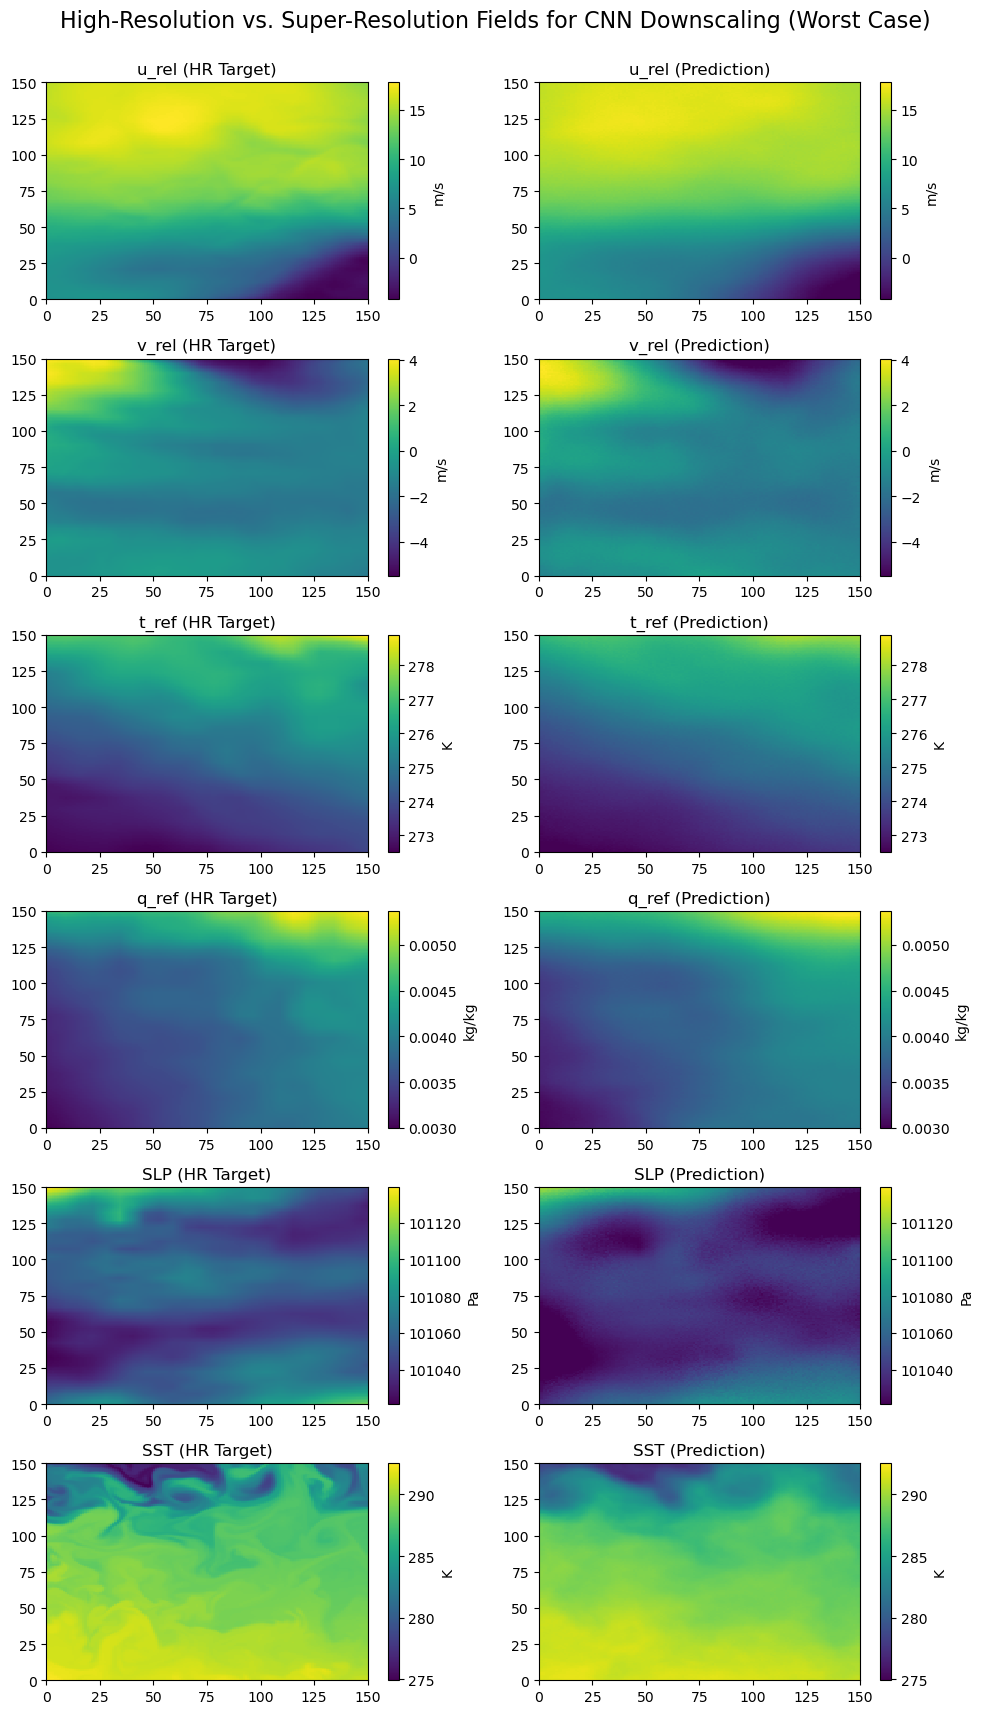

In [42]:
fig, axes = plt.subplots(6, 2, figsize=(10, 18))

vmins = [urel_HR_test[min_idx].min().values, vrel_HR_test[min_idx].min().values, tref_HR_test[min_idx].min().values,
         qref_HR_test[min_idx].min().values, slp_HR_test[min_idx].min().values, sst_HR_test[min_idx].min().values]
vmaxs = [urel_HR_test[min_idx].max().values, vrel_HR_test[min_idx].max().values, tref_HR_test[min_idx].max().values,
         qref_HR_test[min_idx].max().values, slp_HR_test[min_idx].max().values, sst_HR_test[min_idx].max().values]

# Add figure-level title
fig.suptitle("High-Resolution vs. Super-Resolution Fields for CNN Downscaling (Worst Case)", fontsize=16, y=0.95)

# Top-left
im = axes[0, 0].pcolor(urel_HR_test[min_idx], vmin=vmins[0], vmax=vmaxs[0], shading='auto')
axes[0, 0].set_title("u_rel (HR Target)")
fig.colorbar(im, ax=axes[0, 0], label="m/s")

# Top-right
im = axes[0, 1].pcolor(urel_sr_pred[min_idx], vmin=vmins[0], vmax=vmaxs[0], shading='auto')
axes[0, 1].set_title("u_rel (Prediction)")
fig.colorbar(im, ax=axes[0, 1], label="m/s")

# Second row
im = axes[1, 0].pcolor(vrel_HR_test[min_idx], vmin=vmins[1], vmax=vmaxs[1], shading='auto')
axes[1, 0].set_title("v_rel (HR Target)")
fig.colorbar(im, ax=axes[1, 0], label="m/s")

im = axes[1, 1].pcolor(vrel_sr_pred[min_idx], vmin=vmins[1], vmax=vmaxs[1], shading='auto')
axes[1, 1].set_title("v_rel (Prediction)")
fig.colorbar(im, ax=axes[1, 1], label="m/s")

# Third row
im = axes[2, 0].pcolor(tref_HR_test[min_idx], vmin=vmins[2], vmax=vmaxs[2], shading='auto')
axes[2, 0].set_title("t_ref (HR Target)")
fig.colorbar(im, ax=axes[2, 0], label="K")

im = axes[2, 1].pcolor(tref_sr_pred[min_idx], vmin=vmins[2], vmax=vmaxs[2], shading='auto')
axes[2, 1].set_title("t_ref (Prediction)")
fig.colorbar(im, ax=axes[2, 1], label="K")

# Fourth row
im = axes[3, 0].pcolor(qref_HR_test[min_idx], vmin=vmins[3], vmax=vmaxs[3], shading='auto')
axes[3, 0].set_title("q_ref (HR Target)")
fig.colorbar(im, ax=axes[3, 0], label="kg/kg")

im = axes[3, 1].pcolor(qref_sr_pred[min_idx], vmin=vmins[3], vmax=vmaxs[3], shading='auto')
axes[3, 1].set_title("q_ref (Prediction)")
fig.colorbar(im, ax=axes[3, 1], label="kg/kg")

# Fifth row
im = axes[4, 0].pcolor(slp_HR_test[min_idx], vmin=vmins[4], vmax=vmaxs[4], shading='auto')
axes[4, 0].set_title("SLP (HR Target)")
fig.colorbar(im, ax=axes[4, 0], label="Pa")

im = axes[4, 1].pcolor(slp_sr_pred[min_idx], vmin=vmins[4], vmax=vmaxs[4], shading='auto')
axes[4, 1].set_title("SLP (Prediction)")
fig.colorbar(im, ax=axes[4, 1], label="Pa")

# Sixth row
im = axes[5, 0].pcolor(sst_HR_test[min_idx], vmin=vmins[5], vmax=vmaxs[5], shading='auto')
axes[5, 0].set_title("SST (HR Target)")
fig.colorbar(im, ax=axes[5, 0], label="K")

im = axes[5, 1].pcolor(sst_sr_pred[min_idx], vmin=vmins[5], vmax=vmaxs[5], shading='auto')
axes[5, 1].set_title("SST (Prediction)")
fig.colorbar(im, ax=axes[5, 1], label="K")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# SGS HF Contribution Plots

In [1]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
import os
import xrft
import gcm_filters
import random
import scipy
from scipy.ndimage import convolve

warnings.filterwarnings("ignore")

from gcm_filtering import filter_inputs_dataset
from gcm_filtering import filter_inputs

import aerobulk
from aerobulk import noskin

In [2]:
def r2_per_sample(y_true, y_pred):
    n_samples = y_true.shape[0]
    r2_scores = np.empty(n_samples)
    
    for i in range(n_samples):
        yt = y_true[i].reshape(-1)
        yp = y_pred[i].reshape(-1)
        ss_res = np.sum((yt - yp) ** 2)
        ss_tot = np.sum((yt - np.mean(yt)) ** 2)
        r2_scores[i] = 1 - ss_res / ss_tot
    
    return r2_scores

In [3]:
def r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)       # residual sum of squares
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)  # total sum of squares
    return 1 - ss_res / ss_tot

## Import data

In [4]:
ds_all = xr.open_dataset(
"gs://leap-persistent/panalluri/cnn_norm_fluxInputs_global.zarr", engine="zarr", chunks={}
)
ds_all

<xarray.Dataset>
Dimensions:   (time: 1314, y: 150, x: 150)
Dimensions without coordinates: time, y, x
Data variables: (12/18)
    q_ref_hr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    q_ref_lr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    q_ref_sr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    slp_hr    (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    slp_lr    (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    slp_sr    (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    ...        ...
    u_rel_hr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    u_rel_lr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    u_rel_sr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    v_rel_hr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    v_rel_lr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    v_rel_sr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>

## Stats for all samples

In [5]:
ql, qh, taux, tauy, evap =  noskin(
        ds_all.sst_sr,
        ds_all.t_ref_sr,
        ds_all.q_ref_sr,
        ds_all.u_rel_sr,
        ds_all.v_rel_sr,
        slp=ds_all.slp_sr,
        algo='ecmwf',
        zt=2,
        zu=10,
)

heatflux_sr_all = qh + ql

ql, qh, taux, tauy, evap =  noskin(
        ds_all.sst_lr,
        ds_all.t_ref_lr,
        ds_all.q_ref_lr,
        ds_all.u_rel_lr,
        ds_all.v_rel_lr,
        slp=ds_all.slp_lr,
        algo='ecmwf',
        zt=2,
        zu=10,
)

heatflux_lr_all = qh + ql

ql, qh, taux, tauy, evap =  noskin(
        ds_all.sst_hr,
        ds_all.t_ref_hr,
        ds_all.q_ref_hr,
        ds_all.u_rel_hr,
        ds_all.v_rel_hr,
        slp=ds_all.slp_hr,
        algo='ecmwf',
        zt=2,
        zu=10,
)

heatflux_hr_all = qh + ql

In [6]:
# Make a Dataset
ds_heatflux = xr.Dataset()

# Manually add variables
ds_heatflux["heatflux_hr"] = (("time", "yt_ocean", "xt_ocean"), heatflux_lr_all.values)
ds_heatflux["heatflux_lr"] = (("time", "yt_ocean", "xt_ocean"), heatflux_hr_all.values)
ds_heatflux["heatflux_sr"] = (("time", "yt_ocean", "xt_ocean"), heatflux_sr_all.values)

ds_heatflux

<xarray.Dataset>
Dimensions:      (time: 1314, yt_ocean: 150, xt_ocean: 150)
Dimensions without coordinates: time, yt_ocean, xt_ocean
Data variables:
    heatflux_hr  (time, yt_ocean, xt_ocean) float64 215.3 213.7 ... -642.6
    heatflux_lr  (time, yt_ocean, xt_ocean) float64 228.1 228.4 ... -649.4
    heatflux_sr  (time, yt_ocean, xt_ocean) float64 245.1 243.4 ... -544.4

In [7]:
print("Filtering model")
heatflux_smooth = filter_inputs_dataset(ds_heatflux, ['yt_ocean', 'xt_ocean'], filter_scale=50, filter_type='gaussian')
heatflux_smooth

Filtering model


<xarray.Dataset>
Dimensions:      (time: 1314, yt_ocean: 150, xt_ocean: 150)
Dimensions without coordinates: time, yt_ocean, xt_ocean
Data variables:
    heatflux_hr  (time, yt_ocean, xt_ocean) float64 141.9 142.2 ... -468.5
    heatflux_lr  (time, yt_ocean, xt_ocean) float64 154.7 154.7 ... -481.8
    heatflux_sr  (time, yt_ocean, xt_ocean) float64 155.6 155.8 ... -479.1
Attributes:
    filter_scale:  50
    filter_type:   gaussian

In [8]:
HF_SGS_all_pred = heatflux_smooth.heatflux_sr - heatflux_smooth.heatflux_lr
HF_SGS_all_true = heatflux_smooth.heatflux_hr - heatflux_smooth.heatflux_lr

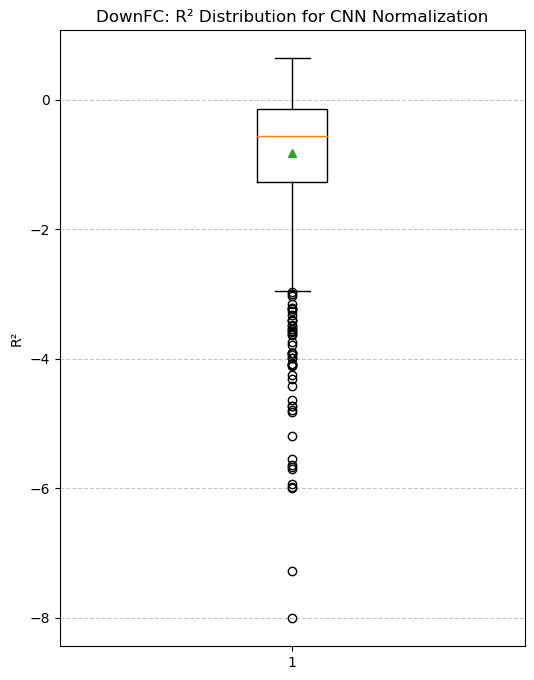

In [9]:
r2_all = r2_per_sample(HF_SGS_all_true.values, HF_SGS_all_pred.values)
plt.figure(figsize=(6, 8))
plt.boxplot(r2_all, vert=True, showmeans=True)
plt.ylabel("R²")
plt.title("DownFC: R² Distribution for CNN Normalization")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Best case results (from SGS HF R2 values)

In [10]:
arr = r2_all

max_val = arr.max()        # get the minimum value
max_idx = arr.argmax()     # get the index of the minimum value

print("Maximum R2 value:", max_val)
print("Index of maximum:", max_idx)

Maximum R2 value: 0.6395053119191649
Index of maximum: 1032


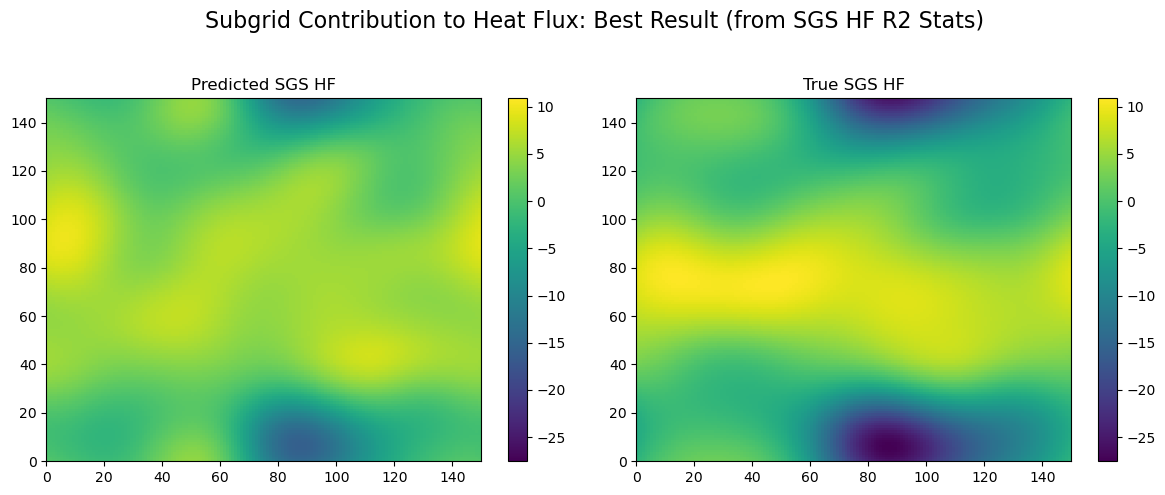

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

data1 = HF_SGS_all_pred.isel(time=max_idx)
data2 = HF_SGS_all_true.isel(time=max_idx)
vmin = min(data1.min(), data2.min()).item()
vmax = max(data1.max(), data2.max()).item()

# Plot predicted
im0 = axes[0].pcolor(data1, vmin=vmin, vmax=vmax)
axes[0].set_title('Predicted SGS HF')
fig.colorbar(im0, ax=axes[0])

# Plot true
im1 = axes[1].pcolor(data2, vmin=vmin, vmax=vmax)
axes[1].set_title('True SGS HF')
fig.colorbar(im1, ax=axes[1])

# Add supertitle
fig.suptitle('Subgrid Contribution to Heat Flux: Best Result (from SGS HF R2 Stats)', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for supertitle
plt.show()

## Worst case results (from SGS HF R2 values)

In [12]:
arr = r2_all

min_val = arr.min()        # get the minimum value
min_idx = arr.argmin()     # get the index of the minimum value

print("Minimum R2 value:", min_val)
print("Index of minimum:", min_idx)

Minimum R2 value: -8.005361385705505
Index of minimum: 347


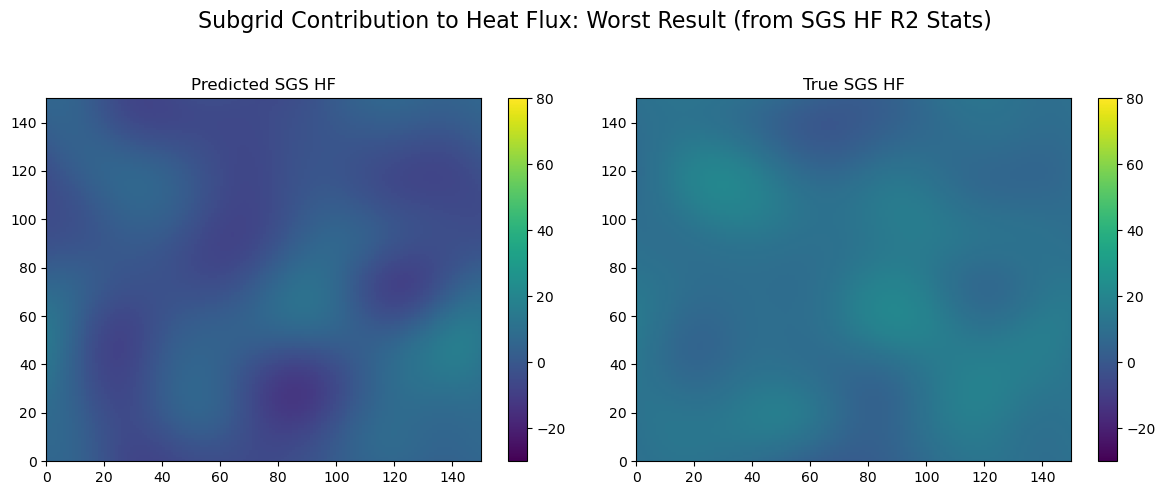

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

data1 = HF_SGS_all_pred.isel(time=min_idx)
data2 = HF_SGS_all_true.isel(time=min_idx)
vmin = min(data1.min(), data2.min()).item()
vmax = max(data1.max(), data2.max()).item()

# Plot predicted
im0 = axes[0].pcolor(data1, vmin=-30, vmax=80)
axes[0].set_title('Predicted SGS HF')
fig.colorbar(im0, ax=axes[0])

# Plot true
im1 = axes[1].pcolor(data2, vmin=-30, vmax=80)
axes[1].set_title('True SGS HF')
fig.colorbar(im1, ax=axes[1])

# Add supertitle
fig.suptitle('Subgrid Contribution to Heat Flux: Worst Result (from SGS HF R2 Stats)', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for supertitle
plt.show()

## Best Case Results (from downscaling R2 values)

In [14]:
max_idx_down = 39
min_idx_down = 100

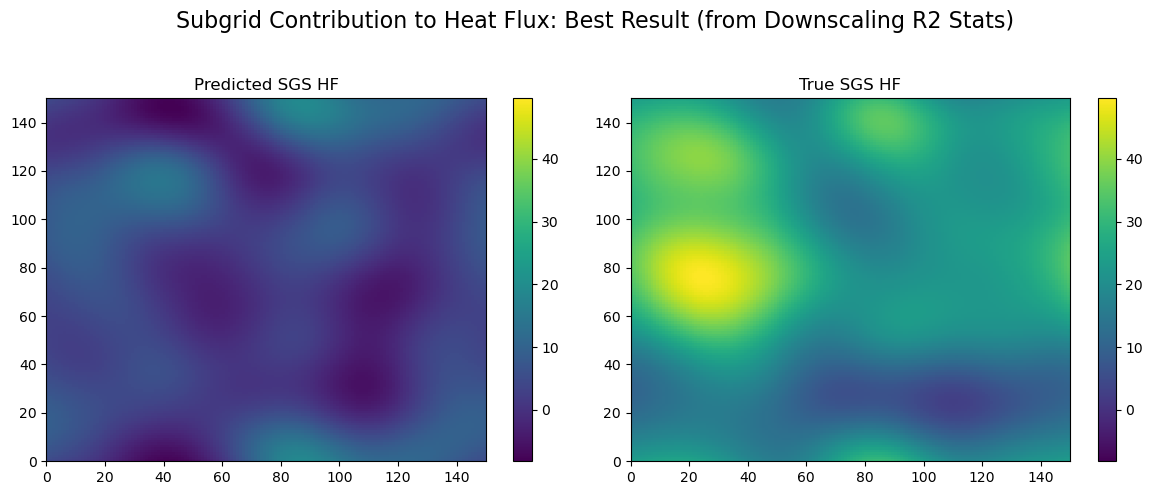

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

data1 = HF_SGS_all_pred.isel(time=max_idx_down)
data2 = HF_SGS_all_true.isel(time=max_idx_down)
vmin = min(data1.min(), data2.min()).item()
vmax = max(data1.max(), data2.max()).item()

# Plot predicted
im0 = axes[0].pcolor(data1, vmin=vmin, vmax=vmax)
axes[0].set_title('Predicted SGS HF')
fig.colorbar(im0, ax=axes[0])

# Plot true
im1 = axes[1].pcolor(data2, vmin=vmin, vmax=vmax)
axes[1].set_title('True SGS HF')
fig.colorbar(im1, ax=axes[1])

# Add supertitle
fig.suptitle('Subgrid Contribution to Heat Flux: Best Result (from Downscaling R2 Stats)', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for supertitle
plt.show()

In [16]:
data1 = HF_SGS_all_pred.isel(time=max_idx_down)
data2 = HF_SGS_all_true.isel(time=max_idx_down)
r2(data1.values, data2.values)

-20.451003923560194

## Worst Case Results (from downscaling R2 values)

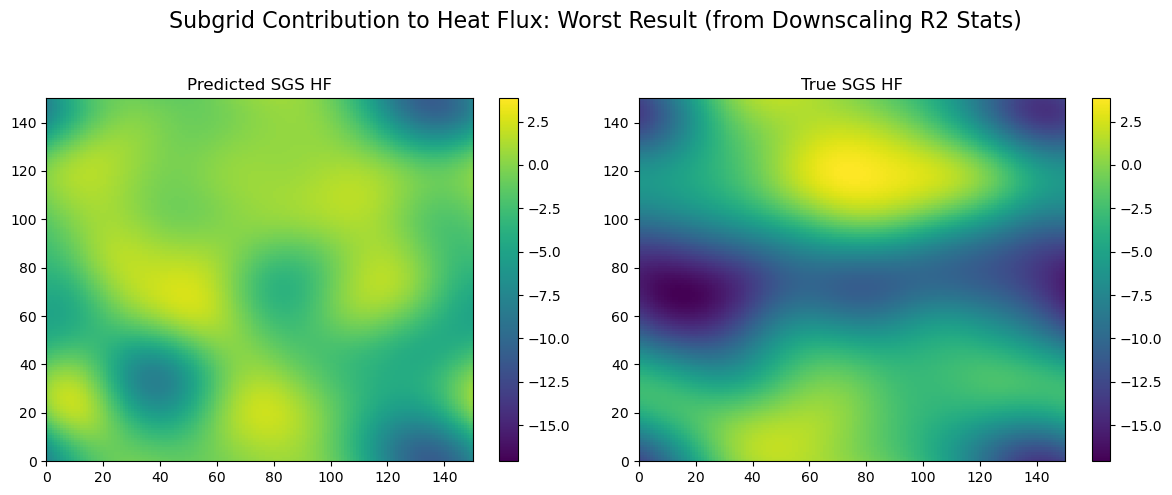

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

data1 = HF_SGS_all_pred.isel(time=min_idx_down)
data2 = HF_SGS_all_true.isel(time=min_idx_down)
vmin = min(data1.min(), data2.min()).item()
vmax = max(data1.max(), data2.max()).item()

# Plot predicted
im0 = axes[0].pcolor(data1, vmin=vmin, vmax=vmax)
axes[0].set_title('Predicted SGS HF')
fig.colorbar(im0, ax=axes[0])

# Plot true
im1 = axes[1].pcolor(data2, vmin=vmin, vmax=vmax)
axes[1].set_title('True SGS HF')
fig.colorbar(im1, ax=axes[1])

# Add supertitle
fig.suptitle('Subgrid Contribution to Heat Flux: Worst Result (from Downscaling R2 Stats)', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for supertitle
plt.show()

In [18]:
data1 = HF_SGS_all_pred.isel(time=min_idx_down)
data2 = HF_SGS_all_true.isel(time=min_idx_down)
r2(data1.values, data2.values)

-5.096189685505738